# Excluding COVID 19

# LIBRARIES

In [1]:
import sys
sys.argv = ['']

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
from datetime import datetime 
import itertools
import argparse 
import re 
import os
import pickle
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import StandardScaler

# ENVIRONMENT

In [2]:
class Environment:
    
    def __init__(self,data,initial_investment,num_stocks):
        
        
        self.data=data
        self.num_samples,self.num_features=self.data.shape
        
        
        
        self.num_stocks=num_stocks
        #self.num_features=total_features-self.num_stocks
        
        self.initial_investment=initial_investment
        self.curr_step=None
        self.stock_owned=None
        self.stock_price=None
        self.stock_features=None
        self.cash_in_hand=None
        
        
        
        self.action_space=np.arange(3**self.num_stocks)
        
        self.action_list = list(map(list, itertools.product(np.arange(self.num_stocks), repeat=self.num_stocks)))
        
        self.state_dim=self.num_features+(self.num_stocks)+1
        self.reset()
        
    def reset(self):
        self.curr_step=0
        self.stock_features=self.data.loc[self.curr_step,['Price_GRAE','Price_SQPH','Price_ACIF','MACD_GRAE','RSI_GRAE','CCI_GRAE','ADX_GRAE','MACD_SQPH','RSI_SQPH','CCI_SQPH','ADX_SQPH','MACD_ACIF','RSI_ACIF','CCI_ACIF','ADX_ACIF','Vol_GRAE','Vol_ACIF','Vol_SQPH']]
        self.stock_price=self.data.loc[self.curr_step,['Price_GRAE','Price_SQPH','Price_ACIF']]
        self.stock_owned=np.zeros(self.num_stocks)
        self.cash_in_hand=self.initial_investment
        
        return self.get_state()
    
    def step(self,action):
        
        previous_value= self.get_value()
        
        self.stock_price=self.data.loc[self.curr_step,['Price_GRAE','Price_SQPH','Price_ACIF']]
        self.stock_features=self.data.loc[self.curr_step,['Price_GRAE','Price_SQPH','Price_ACIF','MACD_GRAE','RSI_GRAE','CCI_GRAE','ADX_GRAE','MACD_SQPH','RSI_SQPH','CCI_SQPH','ADX_SQPH','MACD_ACIF','RSI_ACIF','CCI_ACIF','ADX_ACIF','Vol_GRAE','Vol_ACIF','Vol_SQPH']]
        
        #perform action
        self.trade(action)
        
        self.curr_step+=1
        
        self.stock_price=self.data.loc[self.curr_step,['Price_GRAE','Price_SQPH','Price_ACIF']]
        self.stock_features=self.data.loc[self.curr_step,['Price_GRAE','Price_SQPH','Price_ACIF','MACD_GRAE','RSI_GRAE','CCI_GRAE','ADX_GRAE','MACD_SQPH','RSI_SQPH','CCI_SQPH','ADX_SQPH','MACD_ACIF','RSI_ACIF','CCI_ACIF','ADX_ACIF','Vol_GRAE','Vol_ACIF','Vol_SQPH']]
        
        curr_value=self.get_value()
        
        reward=curr_value-previous_value
        
        
        done= (self.curr_step==self.num_samples-1)
        
        info={'current value' : curr_value}
        
        return self.get_state(),reward,done,info
    
    
    def get_value(self):
        return self.stock_owned.dot(self.stock_price)+self.cash_in_hand
    
    def get_state(self):
        state=np.empty(self.state_dim)
        state[:self.num_features]=self.stock_features
        state[self.num_features:self.num_features+self.num_stocks]=self.stock_owned
        state[-1]=self.cash_in_hand
        
        return state
    
    def trade(self,action):
        # 0:sell
        # 1:hold
        # 2:buy
        action_vector=self.action_list[action]
        
        sell_index=[]
        buy_index=[]
        
        for i in range(len(action_vector)):
            if action_vector[i]==0:
                sell_index.append(i)
            elif action_vector[i]==2:
                buy_index.append(i)
                
                
        if sell_index:
            for i in sell_index:
                self.cash_in_hand=self.cash_in_hand+self.stock_owned[i]*self.stock_price[i]
                self.stock_owned[i]=0
                
        if buy_index:
            can_buy=True
            while can_buy:
                can_buy=False
                for i in buy_index:
                    if self.cash_in_hand>self.stock_price[i]:
                        self.cash_in_hand=self.cash_in_hand-self.stock_price[i]
                        self.stock_owned[i]+=1
                        
                        if self.cash_in_hand > self.stock_price[i]:
                            can_buy = True

# MODEL

In [3]:
class LinearModel:
    # Linear Regression
    def __init__(self,state_dim,action_dim):
        self.W = np.random.randn(state_dim,action_dim) / np.sqrt(state_dim)
        self.b = np.zeros(action_dim)

        # momentum terms 
        self.vW = 0
        self.vb = 0

        self.losses = []
        self.prediction = []
        self.actual_value = []

    def predict(self,X):
        assert(len(X.shape)==2)
        return X.dot(self.W) + self.b

    def sgd(self, X, Y, learning_rate=0.01, momentum=0.9): # Stochastic gradent descent
        assert(len(X.shape)==2)

        num_values=np.prod(Y.shape)

        Yhat= self.predict(X)
        gW= 2*X.T.dot(Yhat - Y)/num_values
        gb= 2*(Yhat-Y).sum(axis=0)/num_values

        self.vW = momentum * self.vW - learning_rate * gW
        self.vb = momentum * self.vb - learning_rate * gb 

        self.W +=  self.vW
        self.b +=  self.vb

        mse = np.mean((Yhat-Y)**2)
        self.losses.append(mse)

    def save_weights(self,filepath):
        np.savez(filepath, W=self.W, b=self.b)

    def load_weights(self,filepath):
        npz = np.load(filepath)
        self.W = npz['W']
        self.b = npz['b']

# AGENT

In [4]:
class Agent(object):
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.gamma = 0.95 # discount factor
        self.epsilon = 1.0 # exploration
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.model = LinearModel(state_size, action_size)
        self.q_value=[]

    def act(self,state): # epsilon-greedy! return integer [1,27]
        if np.random.rand() <= self.epsilon:
            return np.random.choice(self.action_size) # return random action with probability epsilon
        act_values = self.model.predict(state) 
        self.q_value.append(act_values)
        return np.argmax(act_values[0]) # return the best action based on the Q-values with probability 1-epsilon

    def train(self, state, action, reward, next_state, done):
        if done:
            target = reward
        else:
            target = reward + self.gamma * np.amax(self.model.predict(next_state), axis = 1) # Q-Learning

        target_full = self.model.predict(state) # Get the values based on the old parameters W,b
        target_full[0,action] = target # update the entry of the corresponding action

        self.model.sgd(state, target_full) # Stochastic gradient descent. Run one training step and update W, b

        if self.epsilon > self.epsilon_min: #decrease the probability of exploration
            self.epsilon *= self.epsilon_decay

    def load(self,name):
        self.model.load_weights(name)

    def save(self, name):
        self.model.save_weights(name)
    

# TRAIN

2429
1821
608
episode: 1/1200, episode end value: 381455.72, duration: 0:00:04.838053
episode: 2/1200, episode end value: 646349.44, duration: 0:00:08.003579
episode: 3/1200, episode end value: 1636458.62, duration: 0:00:14.845408
episode: 4/1200, episode end value: 1535670.25, duration: 0:00:09.426702
episode: 5/1200, episode end value: 1485983.99, duration: 0:00:06.354501
episode: 6/1200, episode end value: 1127066.11, duration: 0:00:18.366357
episode: 7/1200, episode end value: 1580644.84, duration: 0:00:16.682358
episode: 8/1200, episode end value: 923454.16, duration: 0:00:08.306076
episode: 9/1200, episode end value: 1062173.89, duration: 0:00:12.887575
episode: 10/1200, episode end value: 926301.02, duration: 0:00:11.935482
episode: 11/1200, episode end value: 989841.38, duration: 0:00:17.530529
episode: 12/1200, episode end value: 831748.05, duration: 0:00:10.868689
episode: 13/1200, episode end value: 1044806.10, duration: 0:00:10.466041
episode: 14/1200, episode end value: 16

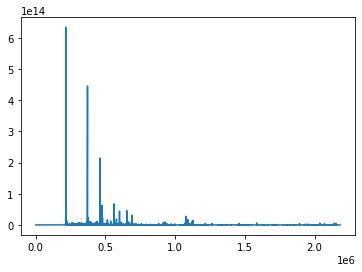

CPU times: total: 4h 17min 42s
Wall time: 4h 27min 31s


In [5]:
%%time

train_flag='train'

def get_data():
    df=pd.read_csv('Stock Data - Excluding COVID 19 .csv')
    df.drop(['Date'],inplace=True,axis=1)
    return df

def scaling(env):
    list_of_states= []
    done = False
    while not done:
        action = np.random.choice(env.action_space)
        state, reward, done, info =env.step(action)

        list_of_states.append(state)

    scaler=StandardScaler()
    scaler.fit(list_of_states)
    return scaler

def make_directory(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)
        
episode_rewards=[]
test_action =[]

def play_one_episode(agent, env, is_train, is_test):
    
    temp_test_action = []
    temp_reward_array=[]
  
    
    state = env.reset() # get the initial state 
    state = scaler.transform([state]) # scale the state vector
    done = False

    while not done:
        action = agent.act(state) # get the next action
        
        if is_test==True:
            temp_test_action.append(action)
            
        next_state, reward, done, info = env.step(action) # perform the action
        temp_reward_array.append(reward)
        next_state = scaler.transform([next_state]) # scale the next state
        
        if is_train == 'train': # if the mode is training
            agent.train(state, action, reward, next_state, done) # Q-Learning with states' aggregation
        state = next_state # got to next state

    episode_rewards.append(temp_reward_array)
    if is_test==True:
        test_action.append(temp_test_action)
        
    return info['current value']



models_folder = 'linear_rl_model_excluding_covid_19-final' # to store the Q-model prarameters
rewards_folder = 'linear_rl_reward_excluding_covid_19-final' # to store the values of episodes


num_episodes= 1200 # epochs
#batch_size = 32
initial_investment = 200000

make_directory(models_folder)
make_directory(rewards_folder)

data=get_data()

n_timesteps,n_features=data.shape

n_train=n_timesteps*3//4

train_data=data.iloc[:n_train,:]
test_data=data.iloc[n_train:,:]

print(len(data))
print(len(train_data))
print(len(test_data))
          
          
env=Environment(train_data,initial_investment,3)
state_size=env.state_dim
action_size=len(env.action_space)
agent=Agent(state_size,action_size)

scaler=scaling(env)

portfolio_value=[]



    
for e in range(num_episodes):
    t0 = datetime.now()
    val = play_one_episode(agent, env, 'train', False)
    dt = datetime.now() - t0

    print(f"episode: {e +1}/{num_episodes}, episode end value: {val:.2f}, duration: {dt}")
    portfolio_value.append(val)
    
    


agent.save(f'{models_folder}/linear.npz')

with open(f'{models_folder}/scaler.pkl', 'wb') as f:
    pickle.dump(scaler,f)

plt.plot(agent.model.losses)
plt.show()

# save portfolio value for each episode
np.save(f'{rewards_folder}/{train_flag}.npy', portfolio_value)
np.save(f'{rewards_folder}/losses.npy', agent.model.losses)

# REWARDS

1200
1820
248.19752484891254


Text(0, 0.5, 'Reward')

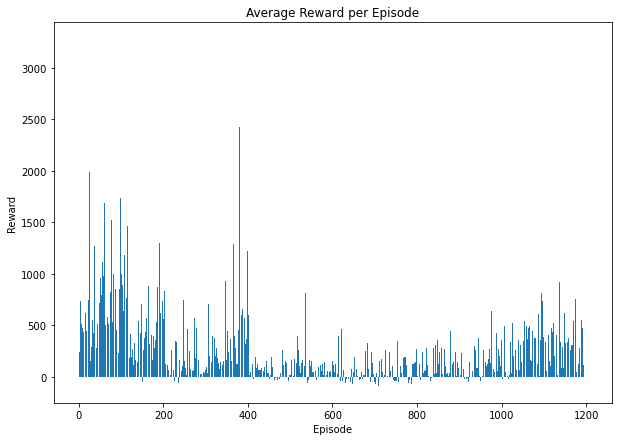

In [6]:
print(len(episode_rewards))
print(len(episode_rewards[0]))

episode_number=[]
average_rewards_all_episodes = []

for i in range(len(episode_rewards)):
    average_rewards_all_episodes.append(sum(episode_rewards[i])/len(episode_rewards[0]))
    episode_number.append(i+1)
    

    
#print(average_rewards_all_episodes)
print(sum(average_rewards_all_episodes)/1200)
plt.figure(figsize=(10,7))
plt.bar(episode_number, list(average_rewards_all_episodes))
plt.title("Average Reward per Episode")
plt.xlabel("Episode")
plt.ylabel("Reward")

# LOSS

3455390114.8580065


Text(0, 0.5, 'Loss')

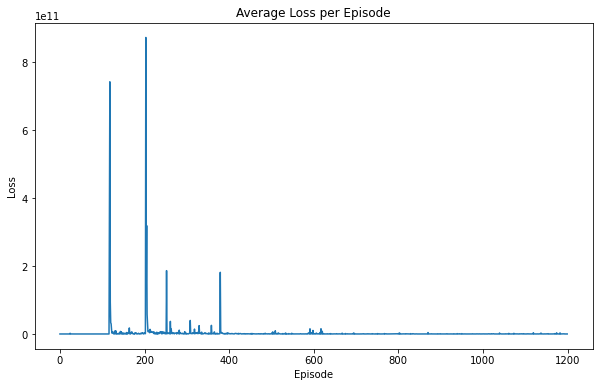

In [7]:
episode_loss = 0
average_loss_per_episode = []
k=0

for j in range(1200):
    for i in range(k,k+1820):
        episode_loss += agent.model.losses[i]
    k+=1820
    average_loss_per_episode.append(episode_loss/1820)
    episode_loss = 0

average_loss_all_episode = sum(average_loss_per_episode)/1200
print(average_loss_all_episode)


plt.figure(figsize=(10,6))
plt.plot(average_loss_per_episode)
plt.title("Average Loss per Episode")
plt.xlabel("Episode")
plt.ylabel("Loss")

In [22]:
train_reward = np.load(r"C:\Users\safae\linear_rl_reward_excluding_covid_19-final\train.npy")
print(len(train_reward))
print("Maximum:            ", max(train_reward))
print("Minimum:            ", min(train_reward))
print("Mean:               ", np.mean(train_reward))
print("Standard Deviation: " ,np.std(train_reward))

1200
Maximum:             6160521.070021578
Minimum:             47078.70000000028
Mean:                651719.4952250213
Standard Deviation:  578890.9381313598


# TEST

In [23]:
%%time

num_episodes=100
train_flag='test'
test_portfolio_value=[]
test_data.reset_index(inplace=True,drop=True)


#load previous scaler
with open(f'{models_folder}/scaler.pkl', 'rb') as f:
    scaler = pickle.load(f)

# remake the env with the test data
test_env = Environment(test_data, initial_investment,3)


agent.epsilon = 0.01
agent.load(f'{models_folder}/linear.npz') 

episode_rewards=[]
    
for e in range(num_episodes):
    t0 = datetime.now()
    val = play_one_episode(agent, test_env, train_flag, True)
    dt = datetime.now() - t0

    print(f"episode: {e +1}/{num_episodes}, episode end value: {val:.2f}, duration: {dt}")
    test_portfolio_value.append(val)
    
np.save(f'{rewards_folder}/{train_flag}.npy', test_portfolio_value)

episode: 1/100, episode end value: 126142.05, duration: 0:00:01.374319
episode: 2/100, episode end value: 123530.33, duration: 0:00:01.382281
episode: 3/100, episode end value: 125193.17, duration: 0:00:01.374342
episode: 4/100, episode end value: 120605.16, duration: 0:00:01.398255
episode: 5/100, episode end value: 120023.16, duration: 0:00:01.389252
episode: 6/100, episode end value: 129313.02, duration: 0:00:01.383332
episode: 7/100, episode end value: 124658.15, duration: 0:00:01.410222
episode: 8/100, episode end value: 126599.63, duration: 0:00:01.364316
episode: 9/100, episode end value: 119740.42, duration: 0:00:01.363387
episode: 10/100, episode end value: 145551.60, duration: 0:00:01.476672
episode: 11/100, episode end value: 120022.36, duration: 0:00:01.406236
episode: 12/100, episode end value: 125053.13, duration: 0:00:01.386256
episode: 13/100, episode end value: 110285.42, duration: 0:00:01.364349
episode: 14/100, episode end value: 131987.17, duration: 0:00:01.391450
e

100
-1234.4841960460471


Text(0, 0.5, 'Reward')

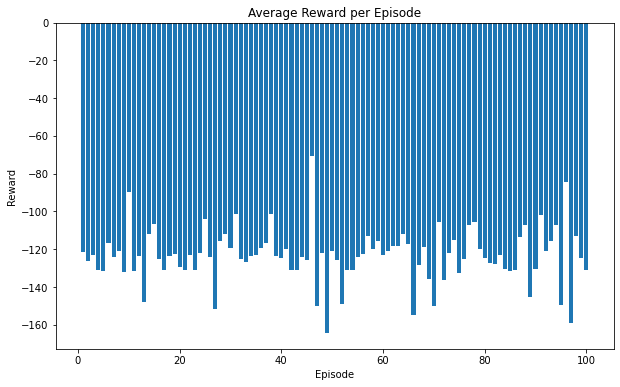

In [24]:
episode_number=[]
average_rewards_all_episodes = []

for i in range(len(episode_rewards)):
    average_rewards_all_episodes.append(sum(episode_rewards[i])/len(episode_rewards[0]))
    episode_number.append(i+1)
    

print(len(episode_rewards)) 
#print(average_rewards_all_episodes)
print(sum(average_rewards_all_episodes)/10)
plt.figure(figsize=(10,6))
plt.bar(episode_number, list(average_rewards_all_episodes) )
plt.title("Average Reward per Episode")
plt.xlabel("Episode")
plt.ylabel("Reward")

In [26]:
test_reward = np.load(r"C:\Users\safae\linear_rl_reward_excluding_covid_19-final\test.npy")
print(len(test_reward))
mean = np.mean(test_reward)
print("Maximum:            ", max(test_reward))
print("Minimum:            ", min(test_reward))
print("Mean:               ", np.mean(test_reward))
print("Standard Deviation: " ,np.std(test_reward))

100
Maximum:             157224.69000001295
Minimum:             100145.24999999555
Mean:                125066.80930000496
Standard Deviation:  8631.064956283572


In [27]:
roi = ((mean-initial_investment)/initial_investment)*100
print(roi)

-37.46659534999752


# GRAPHS

In [62]:
best_test_score_index = average_rewards_all_episodes.index(max(average_rewards_all_episodes))
test_action_list = []

for i in range(len(test_action[0])):
    test_action_list.append(env.action_list[test_action[best_test_score_index][i]])

GRAE = [i[0] for i in test_action_list]
SQPH = [i[1] for i in test_action_list]
ACIF = [i[2] for i in test_action_list]


data = pd.read_csv('Stock Data - Excluding COVID 19 .csv')
n_train=n_timesteps*3//4
test_data=data.iloc[n_train+1:,[0,1,7,13]]
test_data.reset_index(drop =True, inplace=True)

print(len(test_data))
print(len(GRAE))


test_data["GRAE"] = GRAE
test_data["SQPH"] = SQPH
test_data["ACIF"] = ACIF

# 0:sell
# 1:hold
# 2:buy

607
607


In [63]:
test_data.to_csv("Excluding_Covid_19.csv",index = False)

In [3]:
test_data = pd.read_csv("Excluding_Covid_19.csv")
#test_data.drop(["Unnamed: 0"], axis=1, inplace= True)
test_data.head()

,Date,Price_GRAE,Price_SQPH,Price_ACIF,GRAE,SQPH,ACIF
0,2017-08-17,392.0,227.74,197.14,0,1,2
1,2017-08-20,391.5,227.34,201.81,2,1,0
2,2017-08-21,391.9,227.74,198.67,0,1,2
3,2017-08-22,391.3,227.26,201.14,0,1,2
4,2017-08-23,387.4,228.72,201.05,2,1,0


In [4]:
def buy_sell(List):
    length_of_list = len(List)
    first_index_of_zero, first_index_of_two = List.index(0), List.index(2)

    if first_index_of_zero < first_index_of_two:
        current_value, current_index = 0, first_index_of_zero
    else:
        current_value, current_index = 2, first_index_of_two

    if current_index>0:
        List[0:current_index]=[3]*(current_index)

    while True :
        try:
            next_value = 2 - current_value
            next_index = List.index(next_value, current_index)
            List[current_index+1:next_index] = [3]*(next_index-current_index-1)
            current_value, current_index = next_value, next_index
        except ValueError:
            List[current_index+1:length_of_list]=[3]*(length_of_list-current_index-1)
            break
            
grae = list(test_data["GRAE"])
buy_sell(grae)
test_data["GRAE"] = grae

sqph = list(test_data["SQPH"])
buy_sell(sqph)
test_data["SQPH"] = sqph

acif = list(test_data["ACIF"])
buy_sell(acif)
test_data["ACIF"] = acif

In [5]:
print(test_data["GRAE"].value_counts())
print(test_data["SQPH"].value_counts())
print(test_data["ACIF"].value_counts())

3    534
0     37
2     36
Name: GRAE, dtype: int64
3    560
0     24
2     23
Name: SQPH, dtype: int64
3    520
2     44
0     43
Name: ACIF, dtype: int64


In [6]:
test_data["GRAE_sell"]=0
test_data["GRAE_buy"]=0

test_data["SQPH_sell"]=0
test_data["SQPH_buy"]=0

test_data["ACIF_sell"]=0
test_data["ACIF_buy"]=0


for i in range(len(test_data)):
    #GRAE
    if test_data["GRAE"][i]==0:
        test_data["GRAE_sell"][i] = test_data["Price_GRAE"][i]  
    if test_data["GRAE"][i]==2:
        test_data["GRAE_buy"][i] = test_data["Price_GRAE"][i]

      
    #ACIF
    if test_data["ACIF"][i]==0:
        test_data["ACIF_sell"][i] = test_data["Price_ACIF"][i]    
    if test_data["ACIF"][i]==2:
        test_data["ACIF_buy"][i] = test_data["Price_ACIF"][i]
       
    #SQPH
    if test_data["SQPH"][i]==0:
        test_data["SQPH_sell"][i] = test_data["Price_SQPH"][i]
    if test_data["SQPH"][i]==2:
        test_data["SQPH_buy"][i] = test_data["Price_SQPH"][i]

Text(0, 0.5, 'Price')

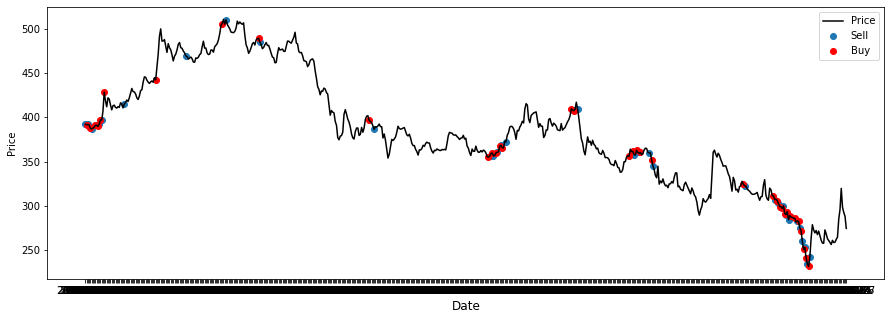

In [7]:
#Grameenphone ltd
plt.figure(figsize=(15,5))
plt.plot(test_data["Date"], test_data["Price_GRAE"],"black")

x=np.array(test_data["Date"])

y=np.array(test_data["GRAE_sell"])
plt.scatter(x=x[y>1], y=y[y>1])


y=np.array(test_data["GRAE_buy"])
plt.scatter(x=x[y>0], y=y[y>0], c="red")

plt.legend(["Price", "Sell" , "Buy"])

plt.xlabel("Date",fontsize=12)
plt.ylabel("Price")

Text(0, 0.5, 'Price')

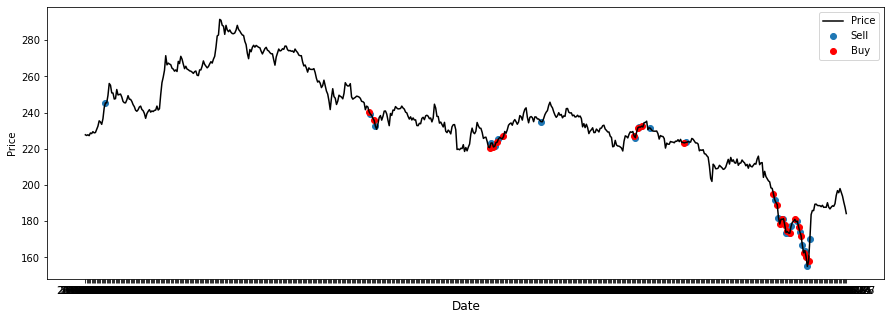

In [8]:
#Square Pharmaceuticals ltd
plt.figure(figsize=(15,5))
plt.plot(test_data["Date"], test_data["Price_SQPH"],"black")

x=np.array(test_data["Date"])

y=np.array(test_data["SQPH_sell"])
plt.scatter(x=x[y>1], y=y[y>1])


y=np.array(test_data["SQPH_buy"])
plt.scatter(x=x[y>0], y=y[y>0], c="red")

plt.legend(["Price", "Sell" , "Buy"])

plt.xlabel("Date",fontsize=12)
plt.ylabel("Price")

Text(0, 0.5, 'Price')

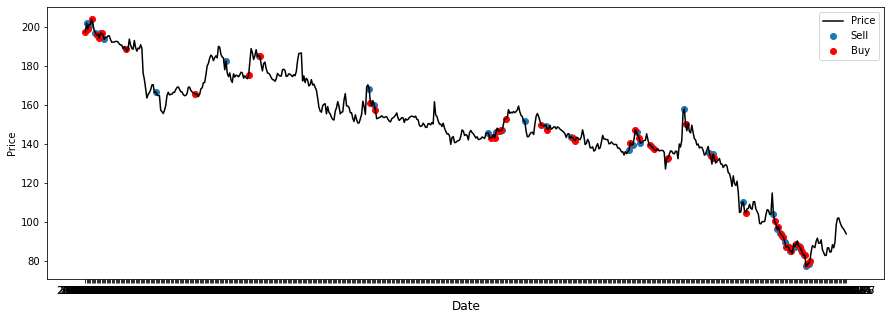

In [9]:
#ACI ltd
plt.figure(figsize=(15,5))
plt.plot(test_data["Date"], test_data["Price_ACIF"],"black")

x=np.array(test_data["Date"])

y=np.array(test_data["ACIF_sell"])
plt.scatter(x=x[y>1], y=y[y>1])


y=np.array(test_data["ACIF_buy"])
plt.scatter(x=x[y>0], y=y[y>0], c="red")

plt.legend(["Price", "Sell" , "Buy"])

plt.xlabel("Date",fontsize=12)
plt.ylabel("Price")